In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np


In [2]:
import pythia8

# Produce leading-order events with Pythia.
pythia = pythia8.Pythia()
pythia.readString("Beams:eCM = 14000.")
pythia.readString("WeakSingleBoson:ffbar2gmZ = on")
pythia.readString("23:onMode = off")
pythia.readString("23:onIfMatch = -13 13")
pythia.readString("PhaseSpace:mHatMin = 80.")
# run(pythia, pyPtZ, 100)
pythia.init(); # this is a noisy line but useful to confirm how Pythia is set up

# help(pythia)

import fastjet as fj



 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.312      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 23 May 2024  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |  | 
 |  |   P       Y      T    H   H  III  A   A    Now is 12 Jul 2024 at 13:53:13    |  | 
 |  |                                                                              |  | 
 |  |   Program docu

In [3]:
n_events = 100
particle_y_cut = 4.5 # cut on hadron rapidity
particle_pt_cut  = 0.5 # cut on hadron pT
min_jet_pt = 10.0 # cut on jet pT

# We will want to make R=0.4 anti-kt jets
jetdef = fj.JetDefinition(fj.antikt_algorithm, 0.4)

pyPtZ = pythia8.Hist("Pythia dN/dpTZ", 100, 0., 100.)
mgPtZ = pythia8.Hist("MadGraph dN/dpTZ", 100, 0., 100.)
amPtZ = pythia8.Hist("aMC@NLO dN/dpTZ", 100, 0., 100.)

In [5]:
# When running Pythia in a notebook, the first generation has to be aborted and then re-started.
# So, hit 'stop' above when this cell triggers the first time, and then move on.
pythia.next()

True

In [6]:
# Generate some leading-order events ...

# We'll store the particles and jets for further study.
# In order to use them with wasserstein & sklearn, we'll use 0-padded np.arrays
    
max_n_jets = 10
max_n_particles = 200

# np.empty gives 0-pads ...

py_events_weights = np.zeros((n_events,1))
py_events_jets = np.zeros((n_events,max_n_jets,3))
py_events_particles = np.zeros((n_events,max_n_particles,3))

####################################
# Outer loop over events
####################################
for idx_event,_ in enumerate(range(n_events)):
   
    if not pythia.next():
        continue

    particles = []

    pidx=0        
    for idx,p in enumerate(pythia.event):
        if p.isFinal() and p.isHadron() and (abs(p.y()) < particle_y_cut) and (p.pT() > particle_pt_cut):                    

            pj = fj.PseudoJet( p.px(), p.py(), p.pz(), p.e() )
            particles.append( pj )

            if(pidx<max_n_particles):
                py_events_particles[idx_event, pidx, 0] = pj.pt()
                py_events_particles[idx_event, pidx, 1] = pj.eta()
                py_events_particles[idx_event, pidx, 2] = pj.phi()
            
            pidx+=1
    
    # Get the jets
    cluster = fj.ClusterSequence(particles, jetdef)
    for jidx in range(0,len(cluster.inclusive_jets(min_jet_pt)),1):
        if(jidx < max_n_jets):
            py_events_jets[idx_event, jidx, 0] = cluster.inclusive_jets(min_jet_pt)[jidx].pt()
            py_events_jets[idx_event, jidx, 1] = cluster.inclusive_jets(min_jet_pt)[jidx].eta()
            py_events_jets[idx_event, jidx, 2] = cluster.inclusive_jets(min_jet_pt)[jidx].phi()
    
    py_events_weights[idx_event] = pythia.infoPython().weight()
    # py_events_particles[idx_event] =  particles
    # py_events_jets[idx_event] = cluster.inclusive_jets(min_jet_pt) # save the jets


In [7]:
# Produce leading-order events with MadGraph 5.

####
# THIS CELL IS BROKEN FOR NOW --MLB
####

# exe = "/users/mleblan6/work/crw-notebooks/mg5amcnlo/bin/mg5_aMC"

# pythia = pythia8.Pythia()
# madgraph = pythia8.LHAupMadgraph(pythia, True, "madgraphrun", exe)
# madgraph.readString("generate p p > mu+ mu-");
# # Note the need for a blank character before "set".
# madgraph.readString(" set ebeam1 6500")
# madgraph.readString(" set ebeam2 6500")
# madgraph.readString(" set mmll 80")
# pythia.setLHAupPtr(madgraph)

# mgPtZ = pythia8.Hist("MadGraph dN/dpTZ", 100, 0., 100.)

# for idx_event,_ in enumerate(range(n_events)):
#     ####################################
#     # Process the events
#     ####################################
    
#     if not pythia.next():
#         continue

#     iMu1 = 0; iMu2 = 0
#     for idx,p in enumerate(pythia.event):
#         if not iMu1 and p.id() == 13:  iMu1 = p.index()
#         if not iMu2 and p.id() == -13: iMu2 = p.index()

#     if iMu1 and iMu2:
#         iMu1 = pythia.event[iMu1].iBotCopyId()
#         iMu2 = pythia.event[iMu2].iBotCopyId()
#         # print(iMu1,iMu2)
#         ptZ = (pythia.event[iMu1].p() + pythia.event[iMu2].p()).pT()
#         # print(ptZ)
    
#     mgPtZ.fill(ptZ)

In [8]:
# Produce next-to-leading-order events with aMC@NLO.

####
# THIS CELL IS BROKEN FOR NOW --MLB
####

# exe = "/users/mleblan6/work/crw-notebooks/mg5amcnlo/bin/mg5_aMC"
# pythia = pythia8.Pythia()
# amcatnlo = pythia8.LHAupMadgraph(pythia, True, "amcatnlorun", exe)
# amcatnlo.readString("generate p p > mu+ mu- [QCD]")
# # Note the need for a blank character before "set".
# amcatnlo.readString(" set ebeam1 6500")
# amcatnlo.readString(" set ebeam2 6500")
# amcatnlo.readString(" set mll 80")
# pythia.setLHAupPtr(amcatnlo);

# amPtZ = pythia8.Hist("aMC@NLO dN/dpTZ", 100, 0., 100.)

# for idx_event,_ in enumerate(range(n_events)):
#     ####################################
#     # Process the events
#     ####################################
    
#     if not pythia.next():
#         continue

#     iMu1 = 0; iMu2 = 0
#     for idx,p in enumerate(pythia.event):
#         if not iMu1 and p.id() == 13:  iMu1 = p.index()
#         if not iMu2 and p.id() == -13: iMu2 = p.index()

#     if iMu1 and iMu2:
#         iMu1 = pythia.event[iMu1].iBotCopyId()
#         iMu2 = pythia.event[iMu2].iBotCopyId()
#         # print(iMu1,iMu2)
#         ptZ = (pythia.event[iMu1].p() + pythia.event[iMu2].p()).pT()
#         # print(ptZ)
    
#     amPtZ.fill(ptZ)

In [9]:
# Turn a few event weights negative -- this is just for prototyping at the moment, as the NLO generation is not working.
import random

count_to_negate = 5
indices_to_negate = random.sample(range(len(py_events_weights)), count_to_negate)
py_events_weights = [-num if i in indices_to_negate else num for i, num in enumerate(py_events_weights)]

# print(py_events_weights)

In [10]:
# Do the EMD calculations ...

%load_ext wurlitzer

R=99.
import wasserstein
calc_emds = wasserstein.PairwiseEMDYPhi(R=R, 
                                        beta=1.0,
                                        norm=True,
                                        num_threads=-1,
                                        print_every=1000,
                                        verbose=1,
                                        # request_mode=False,
                                        store_sym_emds_raw=True,
                                        throw_on_error=False,
                                        # omp_dynamic_chunksize=10,
                                        # n_iter_max=100000,
                                        # epsilon_large_factor=1000.0,
                                        # epsilon_small_factor=1.0,
                                        dtype='float64')

#print(calc_emds)

calc_emds(eventsA=py_events_particles)
emds_arr = calc_emds.emds()
print(emds_arr)


[[0.         0.01868673 0.01418918 ... 0.01591325 0.0144804  0.01709001]
 [0.01868673 0.         0.02156938 ... 0.01063773 0.0117768  0.00931331]
 [0.01418918 0.02156938 0.         ... 0.01863141 0.01770591 0.01941796]
 ...
 [0.01591325 0.01063773 0.01863141 ... 0.         0.01138043 0.01141352]
 [0.0144804  0.0117768  0.01770591 ... 0.01138043 0.         0.01153637]
 [0.01709001 0.00931331 0.01941796 ... 0.01141352 0.01153637 0.        ]]


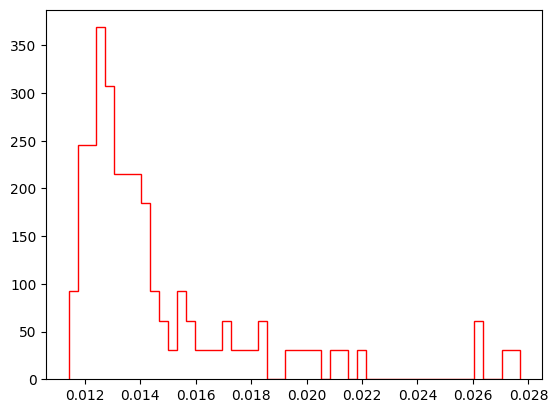

In [11]:
plt.hist(np.mean(emds_arr, axis=0),
        density=True,
        histtype="step",
        color='red',
        bins=50,
        log=False)
plt.show()

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 100 samples in 0.000s...
[t-SNE] Computed neighbors for 100 samples in 0.001s...
[t-SNE] Computed conditional probabilities for sample 100 / 100
[t-SNE] Mean sigma: 0.004579
[t-SNE] KL divergence after 250 iterations with early exaggeration: 52.358395
[t-SNE] KL divergence after 1000 iterations: 0.314191


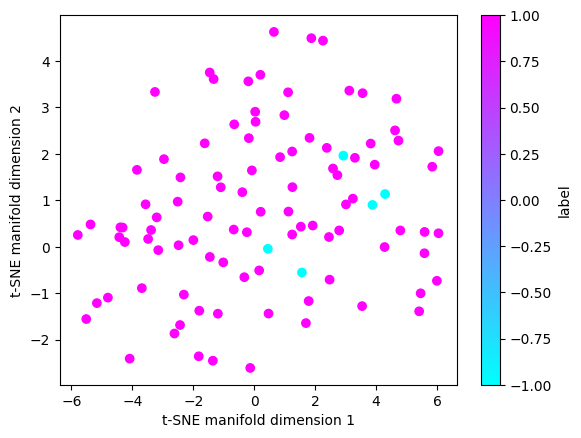

In [16]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2,
            verbose=1,
            #perplexity=45,
            #random_state=122,
            #n_iter=5000,
            metric='precomputed',
            init="random",
            n_jobs=-1)
z = tsne.fit_transform(emds_arr)
    
#cmap='magma','inferno','plasma'

plt.xlabel('t-SNE manifold dimension 1')
plt.ylabel('t-SNE manifold dimension 2')
plt.scatter(z[:,0],z[:,1], c=py_events_weights, cmap='cool')
cbar = plt.colorbar()
cbar.set_label('label')
plt.savefig("tSNE_2d_nModels.png")
plt.show()